##Final model on MobileNetV2

1.   List item
2.   List item



###Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

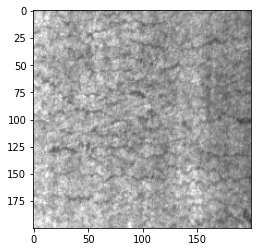

In [ ]:
#Check path is correct or not
img = cv2.imread("/content/gdrive/MyDrive/Btp/IMAGES/crazing_1.jpg", cv2.IMREAD_COLOR)
plt.imshow(img)

###It is used to store data in python list 

In [ ]:
image = []                  # used to store image data /content/gdrive/MyDrive/Object_detection/Data/train/images/img1.jpeg
img_label = []  
           # used to store image label
defect=['pitted_surface_','inclusion_','patches_','crazing_','rolled-in_scale_','scratches_']
for k in range(6):
  for i in range(1,300):
      j= defect[k]+str(i)+'.jpg'
      if ((Path.cwd() / "/content/gdrive/MyDrive/Btp/IMAGES" / j).exists() == True):         # check if image exists or not
          img = cv2.imread("/content/gdrive/MyDrive/Btp/IMAGES/" + j, cv2.IMREAD_COLOR)       # read image using opencv 
          img = cv2.resize(img, (224,224))                                                                   #resize image 
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)                                                                 #resize image 
          img_label.append(defect[k])
          image.append(img) 
          
      else:
         pass

In [ ]:
len(image), len(img_label)

(1765, 1765)

In [ ]:
#total number of original training images
len(image)

1765

In [ ]:
len(img_label)

1765

In [ ]:
#convert into numpy array
image=np.array(image)
img_label=np.array(img_label)

###Visualize the plot of number of training data

(array([293.,   0., 295.,   0., 294.,   0., 294.,   0., 294., 295.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

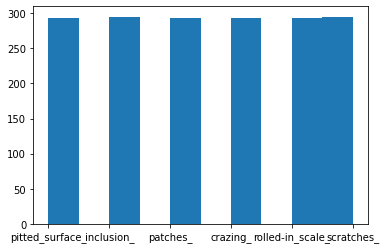

In [ ]:
plt.hist(img_label)

In [ ]:
img_label

array(['pitted_surface_', 'pitted_surface_', 'pitted_surface_', ...,
       'scratches_', 'scratches_', 'scratches_'], dtype='<U16')

In [ ]:
print(image.shape)
print(image.shape[1])
print(image.shape[2])
f = (image.shape[0], image.shape[2])
print(f)

(1765, 224, 224, 3)
224
224
(1765, 224)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image, img_label, test_size = 0.2, random_state = 100)

In [ ]:
test_img=[]
for i in range(len(x_test)):
    test_img.append(x_test[i]/255.0)

In [ ]:
x_test=np.array(test_img)

In [ ]:
df2 = pd.DataFrame(list(zip(x_test, y_test)),columns =['Image','label'])
df2.head()

,Image,label
0,"[[[0.6941176470588235, 0.6941176470588235, 0.6...",patches_
1,"[[[0.41568627450980394, 0.41568627450980394, 0...",scratches_
2,"[[[0.2627450980392157, 0.2627450980392157, 0.2...",scratches_
3,"[[[0.48627450980392156, 0.48627450980392156, 0...",scratches_
4,"[[[0.7725490196078432, 0.7725490196078432, 0.7...",pitted_surface_


In [ ]:
df2=pd.concat([df2['Image'],pd.get_dummies(df2["label"])], axis=1)
df2.head()

,Image,crazing_,inclusion_,patches_,pitted_surface_,rolled-in_scale_,scratches_
0,"[[[0.6941176470588235, 0.6941176470588235, 0.6...",0,0,1,0,0,0
1,"[[[0.41568627450980394, 0.41568627450980394, 0...",0,0,0,0,0,1
2,"[[[0.2627450980392157, 0.2627450980392157, 0.2...",0,0,0,0,0,1
3,"[[[0.48627450980392156, 0.48627450980392156, 0...",0,0,0,0,0,1
4,"[[[0.7725490196078432, 0.7725490196078432, 0.7...",0,0,0,1,0,0


In [ ]:
y_test= df2[df2.columns[1:]].to_numpy()

In [ ]:
y_test.shape

(353, 6)

In [ ]:
x_test=[]
for i in range(len(y_test)):
  x_test.append(df2["Image"][i])
x_test=np.array(x_test)

In [ ]:
x_test.shape

(353, 224, 224, 3)

In [ ]:
#Make a dataframe by concatenating all the numpy array
df1 = pd.DataFrame(list(zip(x_train, y_train)),columns =['Image','label'])
df1.head()

,Image,label
0,"[[[16, 16, 16], [17, 17, 17], [12, 12, 12], [1...",patches_
1,"[[[155, 155, 155], [143, 143, 143], [147, 147,...",rolled-in_scale_
2,"[[[73, 73, 73], [73, 73, 73], [73, 73, 73], [7...",inclusion_
3,"[[[107, 107, 107], [106, 106, 106], [104, 104,...",rolled-in_scale_
4,"[[[143, 143, 143], [138, 138, 138], [138, 138,...",crazing_


##Applied different data-augmentation techniques and try to make balance training samples 

In [ ]:
a_f=[]
a_level=[]
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
])

for i in range(len(x_train)):
  augmented_image = data_augmentation(df1["Image"][i])
  a_f.append(augmented_image)
  a_level.append(df1["label"][i])
  

In [ ]:
len(a_f), len(a_level)

(1412, 1412)

###Added approx 700 blur images

In [ ]:
for i in range(len(x_train)//2):
  x = cv2.blur(np.array(df1["Image"][i]), (3,3))
  a_f.append(x)
  a_level.append(df1["label"][i])

In [ ]:
len(a_f), len(a_level)

(2118, 2118)

In [ ]:
final_train_image = np.array(a_f)
final_train_label = np.array(a_level)

In [ ]:
final_train_image = np.concatenate((final_train_image, x_train), axis=0)
final_train_label = np.concatenate((final_train_label, y_train), axis=0)

In [ ]:
final_train_image.shape, final_train_label.shape

((3530, 224, 224, 3), (3530,))

In [ ]:
#scale data
all_img = []
for i in range(len(final_train_image)):
    all_img.append(final_train_image[i]/255.0)

    

In [ ]:
final_train_image=np.array(all_img)

In [ ]:
final_train_image.shape, final_train_label.shape

((3530, 224, 224, 3), (3530,))

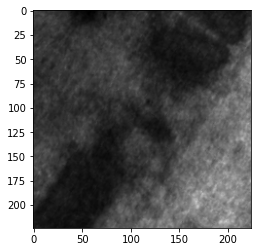

In [ ]:
plt.imshow(final_train_image[0])

(array([592.,   0., 602.,   0., 604.,   0., 584.,   0., 581., 567.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

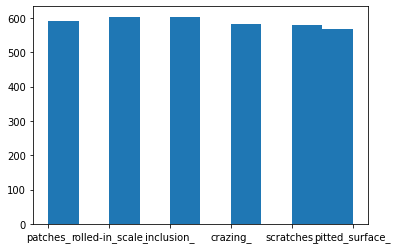

In [ ]:
plt.hist(final_train_label)

In [ ]:
df = pd.DataFrame(list(zip(final_train_image, final_train_label)),columns =['Image','label'])
df.head()

,Image,label
0,"[[[0.29600644, 0.29600644, 0.29600644], [0.295...",patches_
1,"[[[0.5014131, 0.5014131, 0.5014131], [0.495084...",rolled-in_scale_
2,"[[[0.19607843, 0.19607843, 0.19607843], [0.194...",inclusion_
3,"[[[0.50212884, 0.50212884, 0.50212884], [0.496...",rolled-in_scale_
4,"[[[0.67680126, 0.67680126, 0.67680126], [0.657...",crazing_


In [ ]:
df=pd.concat([df['Image'],pd.get_dummies(df["label"])], axis=1)

In [ ]:
df.head()

,Image,crazing_,inclusion_,patches_,pitted_surface_,rolled-in_scale_,scratches_
0,"[[[0.29600644, 0.29600644, 0.29600644], [0.295...",0,0,1,0,0,0
1,"[[[0.5014131, 0.5014131, 0.5014131], [0.495084...",0,0,0,0,1,0
2,"[[[0.19607843, 0.19607843, 0.19607843], [0.194...",0,1,0,0,0,0
3,"[[[0.50212884, 0.50212884, 0.50212884], [0.496...",0,0,0,0,1,0
4,"[[[0.67680126, 0.67680126, 0.67680126], [0.657...",1,0,0,0,0,0


In [ ]:
y_train= df[df.columns[1:]].to_numpy()

In [ ]:
y_train.shape

(3530, 6)

In [ ]:
x=[]
for i in range(len(y_train)):
  x.append(df["Image"][i])


In [ ]:
x_train=np.array(x)

In [ ]:
x_train.shape

(3530, 224, 224, 3)

###Load pretrained model of VGG16

In [ ]:
# from tensorflow.keras.applications import VGG16
# conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)
    model.compile(optimizer=optimizer,               # Compiles the model for training.
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=6
BATCH_SIZE=64
n_steps = len(x_train) // BATCH_SIZE
n_val_steps = len(x_test) // BATCH_SIZE
n_epochs = 5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

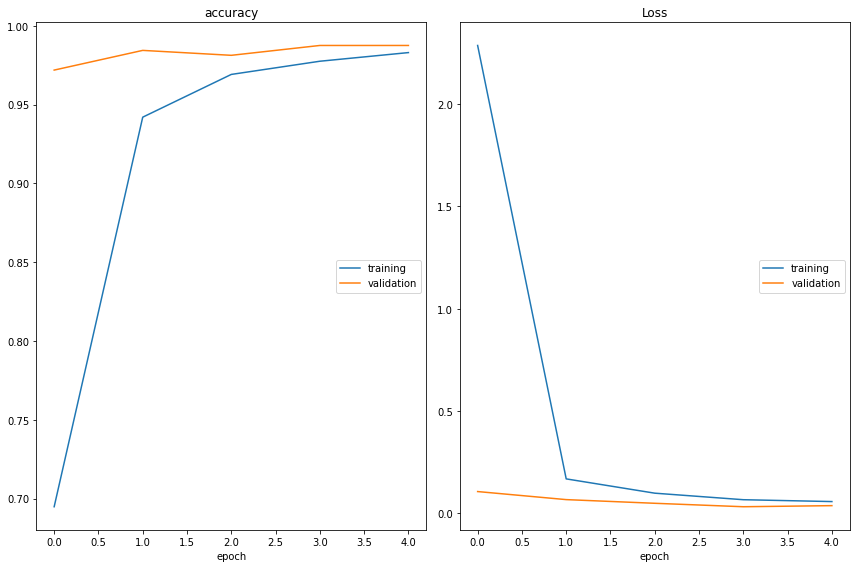

accuracy
	training         	 (min:    0.695, max:    0.983, cur:    0.983)
	validation       	 (min:    0.972, max:    0.988, cur:    0.988)
Loss
	training         	 (min:    0.057, max:    2.287, cur:    0.057)
	validation       	 (min:    0.032, max:    0.106, cur:    0.037)
55/55 [==============================] - 145s 3s/step - loss: 0.0570 - accuracy: 0.9830 - val_loss: 0.0371 - val_accuracy: 0.9875
CPU times: user 6h 52min 15s, sys: 12min 27s, total: 7h 4min 42s
Wall time: 12min 42s


In [ ]:
%%time 

vgg_history = vgg_model.fit(x_train,y_train,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(x_test,y_test),
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
loss , acc = vgg_model.evaluate(x_test, y_test, verbose = 2)
print(acc)

12/12 - 14s - loss: 0.0388 - accuracy: 0.9887 - 14s/epoch - 1s/step
0.9886685609817505


###Classification report 

In [ ]:
from sklearn.metrics import classification_report
pred = vgg_model.predict(x_test, batch_size=128, verbose=1)
predicted = np.argmax(pred, axis=1)


3/3 [==============================] - 13s 4s/step


In [ ]:
y_test=np.argmax(y_test,axis=1)

In [ ]:
report = classification_report(y_test,predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.98      0.94      0.96        54
           2       1.00      1.00      1.00        55
           3       0.97      1.00      0.98        65
           4       1.00      1.00      1.00        55
           5       0.98      0.98      0.98        63

    accuracy                           0.99       353
   macro avg       0.99      0.99      0.99       353
weighted avg       0.99      0.99      0.99       353



##Save model for future use 

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
input_shape = (224, 224, 3)
# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)
num_classes = 6
# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = InceptionV3_model.input, outputs = Custom_Output)
# compile the model
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model.summary()